# Volume - Single Volume Operations

A Volume represents a single 3D or 4D radiology acquisition backed by TileDB. This notebook covers:

- Volume properties and metadata
- **Partial reads** (the key efficiency feature)
- Orthogonal slices: `axial()`, `sagittal()`, `coronal()`
- Arbitrary ROI: `slice()`
- Full volume: `to_numpy()`
- **Analysis methods**: `get_statistics()`, `compute_histogram()`
- **Export**: `to_nifti()`
- Standalone creation: `from_nifti()`, `from_numpy()`

**Prerequisites:** Run [00_ingest_brats.ipynb](./00_ingest_brats.ipynb) first to create the RadiObject.

## Setup

In [1]:
import shutil
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from radiobject.ctx import S3Config, configure
from radiobject.data import S3_REGION, get_brats_uri
from radiobject.radi_object import RadiObject
from radiobject.volume import Volume

BRATS_URI = get_brats_uri()
print(f"RadiObject URI: {BRATS_URI}")

RadiObject URI: /Users/samueldsouza/Desktop/Code/RadiObject/data/brats_radiobject


In [2]:
# Configure S3 if using S3 URI
if BRATS_URI.startswith("s3://"):
    configure(s3=S3Config(region=S3_REGION))

## Load RadiObject from URI

In [3]:
radi = RadiObject(BRATS_URI)
radi

RadiObject(5 subjects, 4 collections: [T2w, T1gd, T1w, FLAIR])

## Getting a Volume

Access volumes through collections. No data is loaded until you request it.

In [4]:
# Get a volume (lazy - no data loaded yet)
vol = radi.FLAIR.iloc[0]
vol

Volume(shape=240x240x155, dtype=float32, obs_id='BRATS_001_FLAIR')

## Volume Properties

In [5]:
print(f"Shape: {vol.shape}")
print(f"Dimensions: {vol.ndim}D")
print(f"Data type: {vol.dtype}")
print(f"Observation ID: {vol.obs_id}")

Shape: (240, 240, 155)
Dimensions: 3D
Data type: float32
Observation ID: BRATS_001_FLAIR


In [6]:
# Orientation metadata
orient_info = vol.orientation_info
if orient_info:
    print(f"Axis codes: {orient_info.axcodes}")
    print(f"Is canonical (RAS): {orient_info.is_canonical}")
    print(f"Source: {orient_info.source}")

Axis codes: ('R', 'A', 'S')
Is canonical (RAS): True
Source: identity


## Partial Reads - The Key Efficiency Feature

TileDB enables reading only the data you need, without loading the entire volume into memory. This is critical for:

- **Large datasets** that don't fit in RAM
- **Quick previews** and exploratory analysis
- **Slice-by-slice processing** pipelines

### Orthogonal Slices: `axial()`, `sagittal()`, `coronal()`

In [7]:
# Partial reads - only the requested slice is loaded
axial = vol.axial(z=77)  # X-Y plane at Z=77
sagittal = vol.sagittal(x=120)  # Y-Z plane at X=120
coronal = vol.coronal(y=120)  # X-Z plane at Y=120

print(f"Axial shape: {axial.shape}")
print(f"Sagittal shape: {sagittal.shape}")
print(f"Coronal shape: {coronal.shape}")

Axial shape: (240, 240)
Sagittal shape: (240, 155)
Coronal shape: (240, 155)


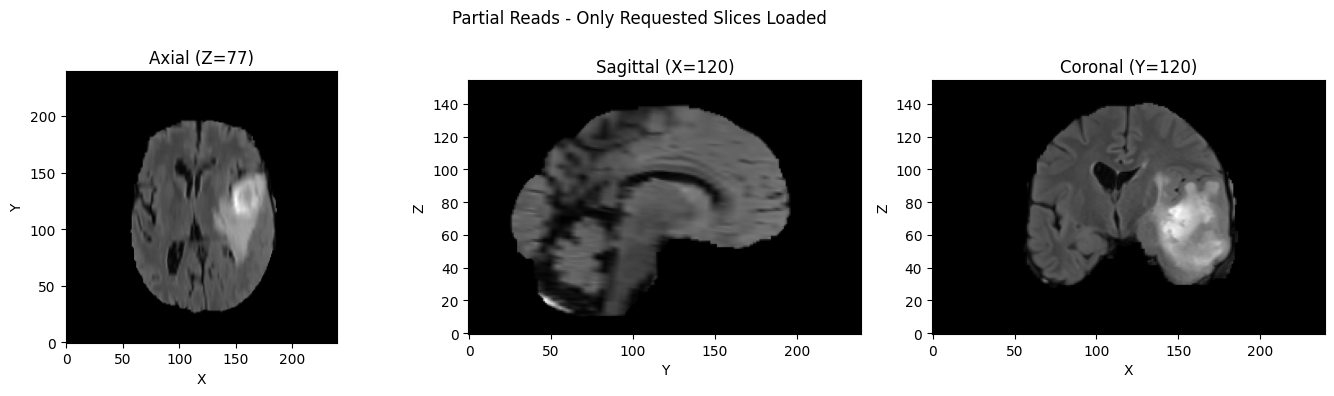

In [8]:
# Visualize orthogonal views
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].imshow(axial.T, cmap="gray", origin="lower")
axes[0].set_title("Axial (Z=77)")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

axes[1].imshow(sagittal.T, cmap="gray", origin="lower")
axes[1].set_title("Sagittal (X=120)")
axes[1].set_xlabel("Y")
axes[1].set_ylabel("Z")

axes[2].imshow(coronal.T, cmap="gray", origin="lower")
axes[2].set_title("Coronal (Y=120)")
axes[2].set_xlabel("X")
axes[2].set_ylabel("Z")

plt.suptitle("Partial Reads - Only Requested Slices Loaded")
plt.tight_layout()
plt.show()

### Arbitrary ROI: `slice()`

Read any 3D region of interest.

In [9]:
# Read a 3D ROI (e.g., tumor region)
roi = vol.slice(
    x=slice(80, 160),  # X: 80-160
    y=slice(80, 160),  # Y: 80-160
    z=slice(60, 100),  # Z: 60-100
)

print(f"ROI shape: {roi.shape}")

ROI shape: (80, 80, 40)


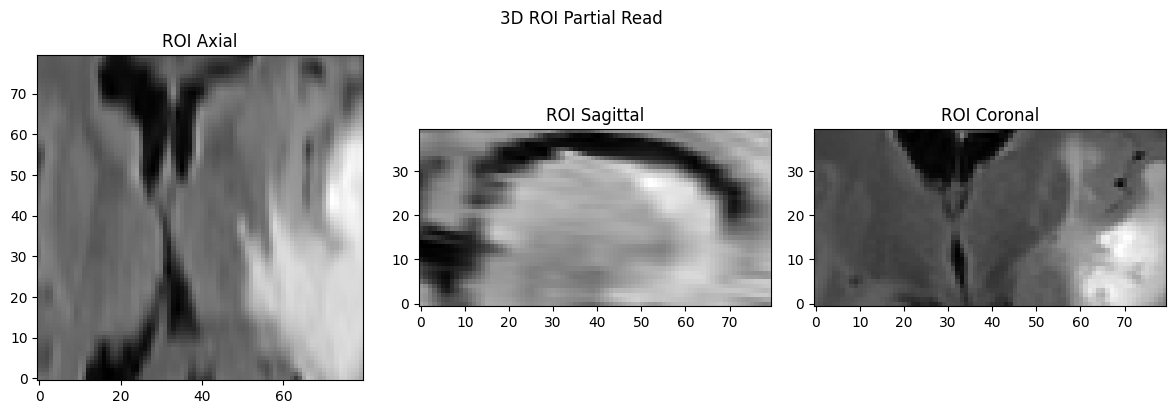

In [10]:
# Visualize the ROI
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

mid_z, mid_x, mid_y = roi.shape[2] // 2, roi.shape[0] // 2, roi.shape[1] // 2

axes[0].imshow(roi[:, :, mid_z].T, cmap="gray", origin="lower")
axes[0].set_title("ROI Axial")

axes[1].imshow(roi[mid_x, :, :].T, cmap="gray", origin="lower")
axes[1].set_title("ROI Sagittal")

axes[2].imshow(roi[:, mid_y, :].T, cmap="gray", origin="lower")
axes[2].set_title("ROI Coronal")

plt.suptitle("3D ROI Partial Read")
plt.tight_layout()
plt.show()

### Memory Comparison

In [11]:
# Compare memory usage: partial vs full read
full_size = np.prod(vol.shape) * 4  # float32 = 4 bytes
roi_size = roi.nbytes
slice_size = axial.nbytes

print(f"Full volume: {full_size / 1024:.1f} KB")
print(f"3D ROI (80x80x40): {roi_size / 1024:.1f} KB ({full_size/roi_size:.1f}x smaller)")
print(f"Single slice (240x240): {slice_size / 1024:.1f} KB ({full_size/slice_size:.1f}x smaller)")

Full volume: 34875.0 KB
3D ROI (80x80x40): 1000.0 KB (34.9x smaller)
Single slice (240x240): 225.0 KB (155.0x smaller)


## Full Volume: `to_numpy()`

When you need the complete volume (e.g., for ML training or whole-volume analysis).

In [12]:
# Load full volume into memory
full_data = vol.to_numpy()

print(f"Shape: {full_data.shape}")
print(f"Memory: {full_data.nbytes / (1024*1024):.2f} MB")
print("\nIntensity statistics:")
print(f"  Min: {full_data.min():.2f}")
print(f"  Max: {full_data.max():.2f}")
print(f"  Mean: {full_data.mean():.2f}")
print(f"  Std: {full_data.std():.2f}")

Shape: (240, 240, 155)
Memory: 34.06 MB

Intensity statistics:
  Min: 0.00
  Max: 1829.00
  Mean: 86.02
  Std: 210.89


## Analysis Methods

### Statistics: `get_statistics()`

In [13]:
# Compute descriptive statistics
stats = vol.get_statistics(percentiles=[5, 25, 75, 95])

print("Volume Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value:.2f}")

Volume Statistics:
  mean: 86.02
  std: 210.89
  min: 0.00
  max: 1829.00
  median: 0.00
  p5: 0.00
  p25: 0.00
  p75: 0.00
  p95: 586.00


### Histogram: `compute_histogram()`

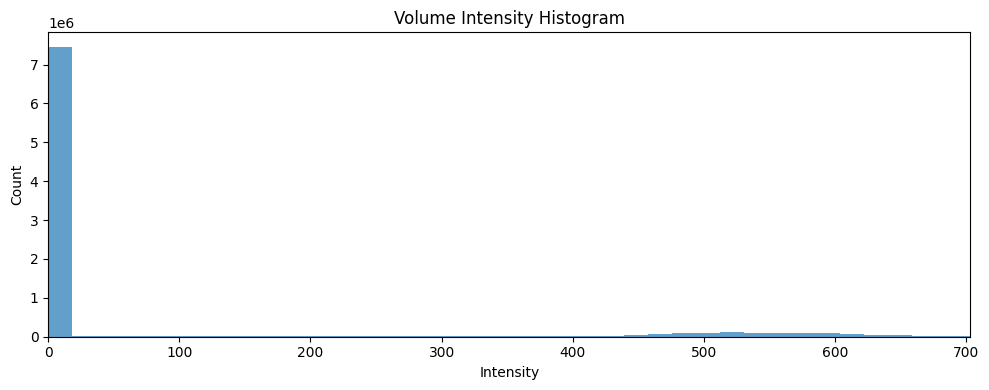

In [14]:
# Compute and visualize histogram
hist_counts, bin_edges = vol.compute_histogram(bins=100)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(bin_edges[:-1], hist_counts, width=np.diff(bin_edges), align="edge", alpha=0.7)
ax.set_xlabel("Intensity")
ax.set_ylabel("Count")
ax.set_title("Volume Intensity Histogram")
ax.set_xlim(0, stats["p95"] * 1.2)  # Focus on main distribution
plt.tight_layout()
plt.show()

### Export: `to_nifti()`

In [15]:
# Export volume to NIfTI
TEMP_DIR = tempfile.mkdtemp(prefix="vol_demo_")
export_path = Path(TEMP_DIR) / "exported_flair.nii.gz"
vol.to_nifti(export_path)

# Verify export
exported = nib.load(export_path)
print(f"Exported to: {export_path}")
print(f"Shape: {exported.shape}")
print(f"Data matches: {np.allclose(vol.to_numpy(), np.asarray(exported.dataobj))}")

# Cleanup
shutil.rmtree(TEMP_DIR)

Exported to: /var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn/T/vol_demo_aenzqskx/exported_flair.nii.gz
Shape: (240, 240, 155)
Data matches: True


## Visualization Patterns

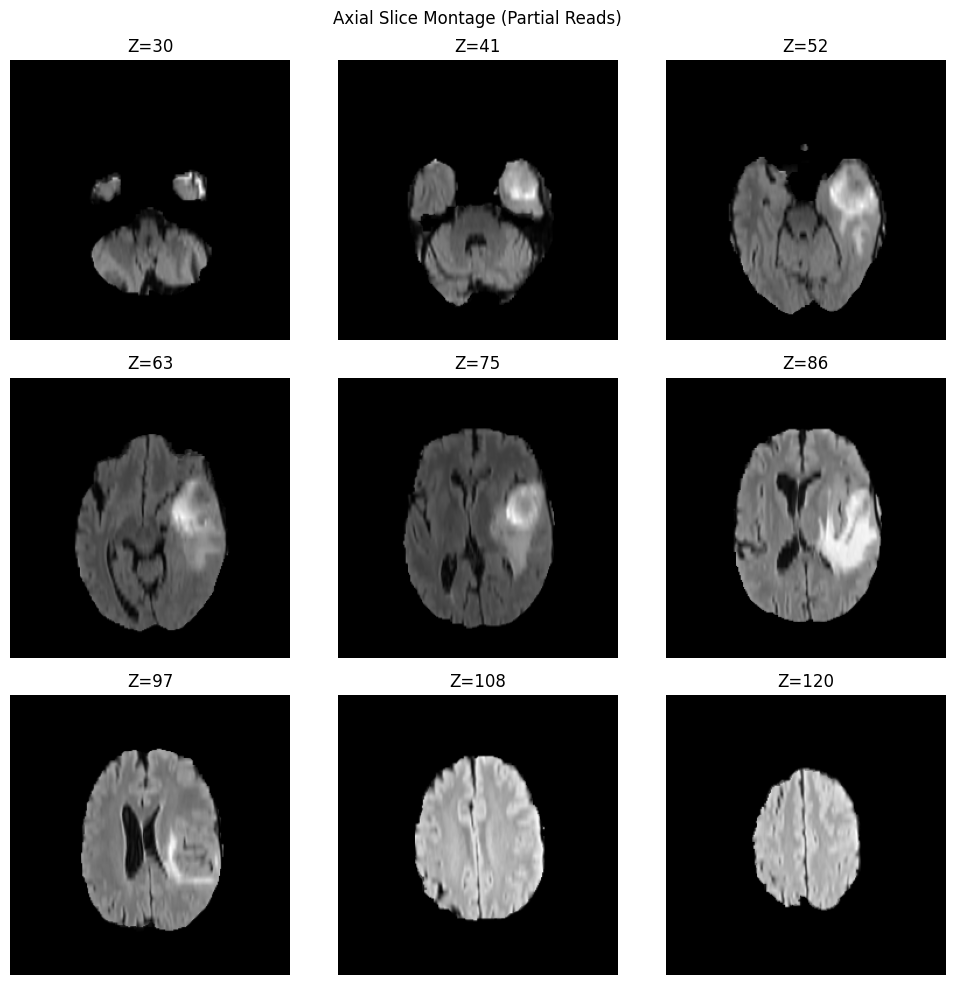

In [16]:
# Axial slice montage
n_slices = 9
z_indices = np.linspace(30, 120, n_slices, dtype=int)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax, z in zip(axes.flat, z_indices):
    ax.imshow(vol.axial(z).T, cmap="gray", origin="lower")
    ax.set_title(f"Z={z}")
    ax.axis("off")

plt.suptitle("Axial Slice Montage (Partial Reads)")
plt.tight_layout()
plt.show()

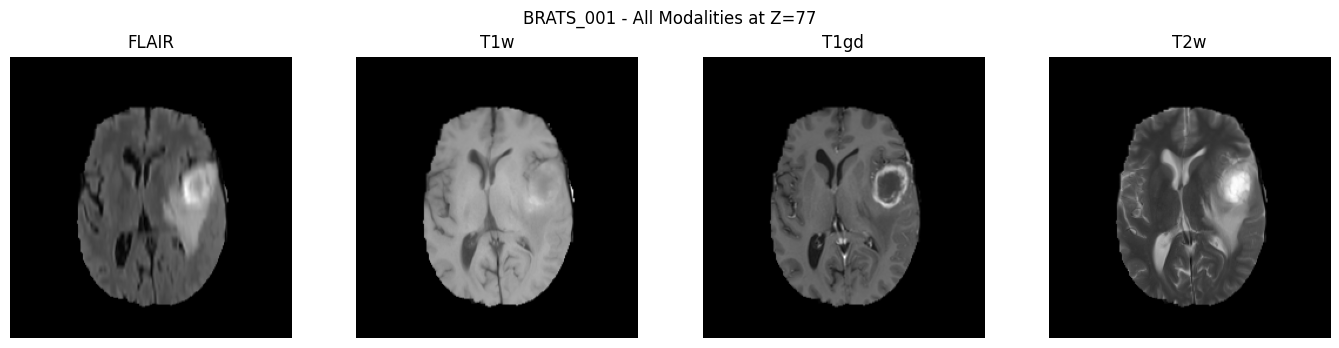

In [17]:
# Compare modalities at same location
subject_ids = radi.obs_subject_ids
subject_id = subject_ids[0]
z = 77
modalities = ["FLAIR", "T1w", "T1gd", "T2w"]

fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))
for i, mod in enumerate(modalities):
    vol_mod = radi.collection(mod).loc[f"{subject_id}_{mod}"]
    axes[i].imshow(vol_mod.axial(z).T, cmap="gray", origin="lower")
    axes[i].set_title(mod)
    axes[i].axis("off")

plt.suptitle(f"{subject_id} - All Modalities at Z={z}")
plt.tight_layout()
plt.show()

## Standalone Volume Creation

Create volumes directly without a RadiObject.

In [18]:
# Create from NumPy array
TEMP_DIR = tempfile.mkdtemp(prefix="vol_demo_")

synthetic_data = np.random.randn(64, 64, 32).astype(np.float32)
vol_from_numpy = Volume.from_numpy(
    uri=str(Path(TEMP_DIR) / "synthetic_vol"),
    data=synthetic_data,
)
print(f"Volume from NumPy: {vol_from_numpy}")

# Cleanup
shutil.rmtree(TEMP_DIR)

Volume from NumPy: Volume(shape=64x64x32, dtype=float32)


In [19]:
# Example: Creating from NIfTI file
print("""To create a volume from a NIfTI file:

from radiobject.volume import Volume

vol = Volume.from_nifti(
    uri="./my_volume",
    nifti_path="/path/to/scan.nii.gz",
)
""")

To create a volume from a NIfTI file:

from radiobject.volume import Volume

vol = Volume.from_nifti(
    uri="./my_volume",
    nifti_path="/path/to/scan.nii.gz",
)



## 4D Volumes

Volumes can be 4D (e.g., fMRI time series). The `t` parameter is optional in slice methods.

In [20]:
# Create a 4D volume (simulated fMRI)
TEMP_DIR = tempfile.mkdtemp(prefix="vol_demo_")

fmri_data = np.random.randn(64, 64, 32, 100).astype(np.float32)
vol_4d = Volume.from_numpy(
    uri=str(Path(TEMP_DIR) / "fmri_vol"),
    data=fmri_data,
)

print(f"4D Volume: {vol_4d}")

# Partial read at specific time point
slice_t10 = vol_4d.axial(z=16, t=10)
print(f"Axial at Z=16, T=10: shape {slice_t10.shape}")

# Cleanup
shutil.rmtree(TEMP_DIR)

4D Volume: Volume(shape=64x64x32x100, dtype=float32)
Axial at Z=16, T=10: shape (64, 64)


## What Can I Do with a Volume?

### Reading Data
| Method | Returns | Memory | Use Case |
|--------|---------|--------|----------|
| `vol.axial(z)` | 2D ndarray | ~225 KB | Quick preview, slice viewing |
| `vol.sagittal(x)` | 2D ndarray | ~140 KB | Cross-sectional analysis |
| `vol.coronal(y)` | 2D ndarray | ~140 KB | Frontal plane viewing |
| `vol.slice(x, y, z)` | 3D ndarray | Variable | ROI extraction |
| `vol.to_numpy()` | 3D ndarray | ~34 MB | Full volume (ML training) |

### Analysis
| Method | Returns | Use Case |
|--------|---------|----------|
| `vol.get_statistics()` | dict | Mean, std, min, max, percentiles |
| `vol.compute_histogram()` | (counts, edges) | Intensity distribution |

### Properties
| Property | Returns | Description |
|----------|---------|-------------|
| `vol.shape` | tuple | (X, Y, Z) or (X, Y, Z, T) |
| `vol.dtype` | numpy dtype | Data type (e.g., float32) |
| `vol.obs_id` | str | Unique volume identifier |
| `vol.orientation_info` | OrientationInfo | Anatomical orientation (RAS, etc.) |

### Export
| Method | Use Case |
|--------|----------|
| `vol.to_nifti(path)` | Export for external tools (FSL, FreeSurfer, etc.) |

**Key takeaway:** Use partial reads (`axial`, `sagittal`, `coronal`, `slice`) for exploration. Use analysis methods (`get_statistics`, `compute_histogram`) for quantitative assessment. Reserve `to_numpy()` for when you need the full volume.

## Next Steps

- [04_storage_configuration.ipynb](./04_storage_configuration.ipynb) - Optimize tile orientation for your analysis pattern